In [5]:
import spacy
from spacy import displacy
import visualise_spacy_tree
from IPython.display import Image

## Create model

In [98]:
my_file = open("drugs list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
drugs_list = []
for i in my_file:
    drugs_list.append(i.replace('\n', ''))

my_file = open("countries list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
countries_list = []
for i in my_file:
    countries_list.append(i.replace('\n', ''))
        

In [111]:
def configure_spacy_model():
    # Create dict of drug pattern and quantity pattern
    pattern_list = []
    
    drugs_ent_list = []
    for i in drugs_list:
        pattern_list.append({"label": "DRUG", "pattern": [{"lower": i}]})
    
    quantity_rule = {"label": "QUANTITY", "pattern": [{"IS_DIGIT": True}, {"LOWER": "gram"}]}
    pattern_list.append(quantity_rule)
    
    for i in countries_list:
        pattern_list.append({"label": "GPE", "pattern": [{"lower": i.replace(' ', '').lower()}]})
    
    # Add drug and quantity rules to the model
    config = {
   "phrase_matcher_attr": None,
   "validate": True,
   "overwrite_ents": True,
   "ent_id_sep": "||",
    }
    ruler = nlp.add_pipe("entity_ruler", config=config)

    #List of Entities and Patterns
#     patterns = drugs_ent_list
    ruler.add_patterns(pattern_list)


In [112]:
import spacy
from spacy import displacy
# !python -m spacy download nl_core_news_md
nlp = spacy.load('nl_core_news_md')
configure_spacy_model()

In [113]:
def extract_chunk_info(txt):
    source_country = None
    total_info = []
    for token in nlp(txt):
        info = {}
        drug_info = {}
        countries = []
        
        if token.ent_type_ == "DRUG":
            info = {"drug": token.text}
            
            ## Get source and destination
            for ancestor in token.ancestors:
                for nephew in ancestor.children:
                    if nephew.ent_type_ == "GPE" or nephew.ent_type_ == "LOC":
                        countries.append(nephew)
                        for child in nephew.children:
                            if child.dep_ == "conj" and child.ent_type_ == "GPE" or child.ent_type_ == "LOC":
                                countries.append(child.text)
                            elif child.pos_ == "ADP" and child.dep_ == "case":
                                adj = child.text
            if len(countries) > 0 :
                try:
                    info[adj] = countries
                except:
                    info['land'] = countries
            
                        
            ## Get volume
            for ancestors in token.ancestors:
                for nephew in ancestors.children:
                    if nephew.ent_type_ == "QUANTITY" or nephew.ent_type_ == "CARDINAL":
                        for second_nephew in nephew.children:
                            if second_nephew.is_digit != nephew.is_digit:
                                if second_nephew.is_digit:
                                    info['volume'] = second_nephew.text
                                    info['volume_type'] = nephew.text
                                else:
                                    info['volume'] = nephew.text
                                    info['volume_type'] = second_nephew.text
            if 'volume' not in info:
                for child in token.children:
                    if (child.dep_ == "det" and child.like_num) or (child.dep_ == "nummod"):
                        info['volume'] = child.text
                                
        if len(info) > 0:
#             print(info)
            total_info.append(info)
    return total_info

'Het Gerecht neemt op dit onderdeel mede in aanmerking dat het uiterst onwaarschijnlijk is dat derden die zoveel cocaïne naar SintMaarten willen smokkelen daarvoor een manier kiezen die het uiterst onzeker maakt of de cocaïne uiteindelijk wel wordt meegenomen en afgegeven. '

[{'drug': 'cocaïne', 'naar': [SintMaarten], 'volume': 'zoveel'},
 {'drug': 'cocaïne'}]

## b

In [120]:
txtcol = []
txtcol.append('Het Gerecht neemt op dit onderdeel mede in aanmerking dat het uiterst onwaarschijnlijk is dat derden die zoveel cocaïne naar Sint Maarten willen smokkelen daarvoor een manier kiezen die het uiterst onzeker maakt of de cocaïne uiteindelijk wel wordt meegenomen en afgegeven. ')





In [122]:
def fix_countries(text):
    for country in countries_list:
        text = text.replace(country, country.replace(' ', ''))
    return text


In [123]:
extract_chunk_info(fix_countries(txt))

[{'drug': 'cocaïne', 'naar': [SintMaarten], 'volume': 'zoveel'},
 {'drug': 'cocaïne'}]

In [119]:
displacy.render(nlp(txt), style='dep')

In [116]:
displacy.render(nlp(txt), style='ent')


In [117]:
extract_chunk_info(txt)

[{'drug': 'cocaïne', 'naar': [SintMaarten], 'volume': 'zoveel'},
 {'drug': 'cocaïne'}]

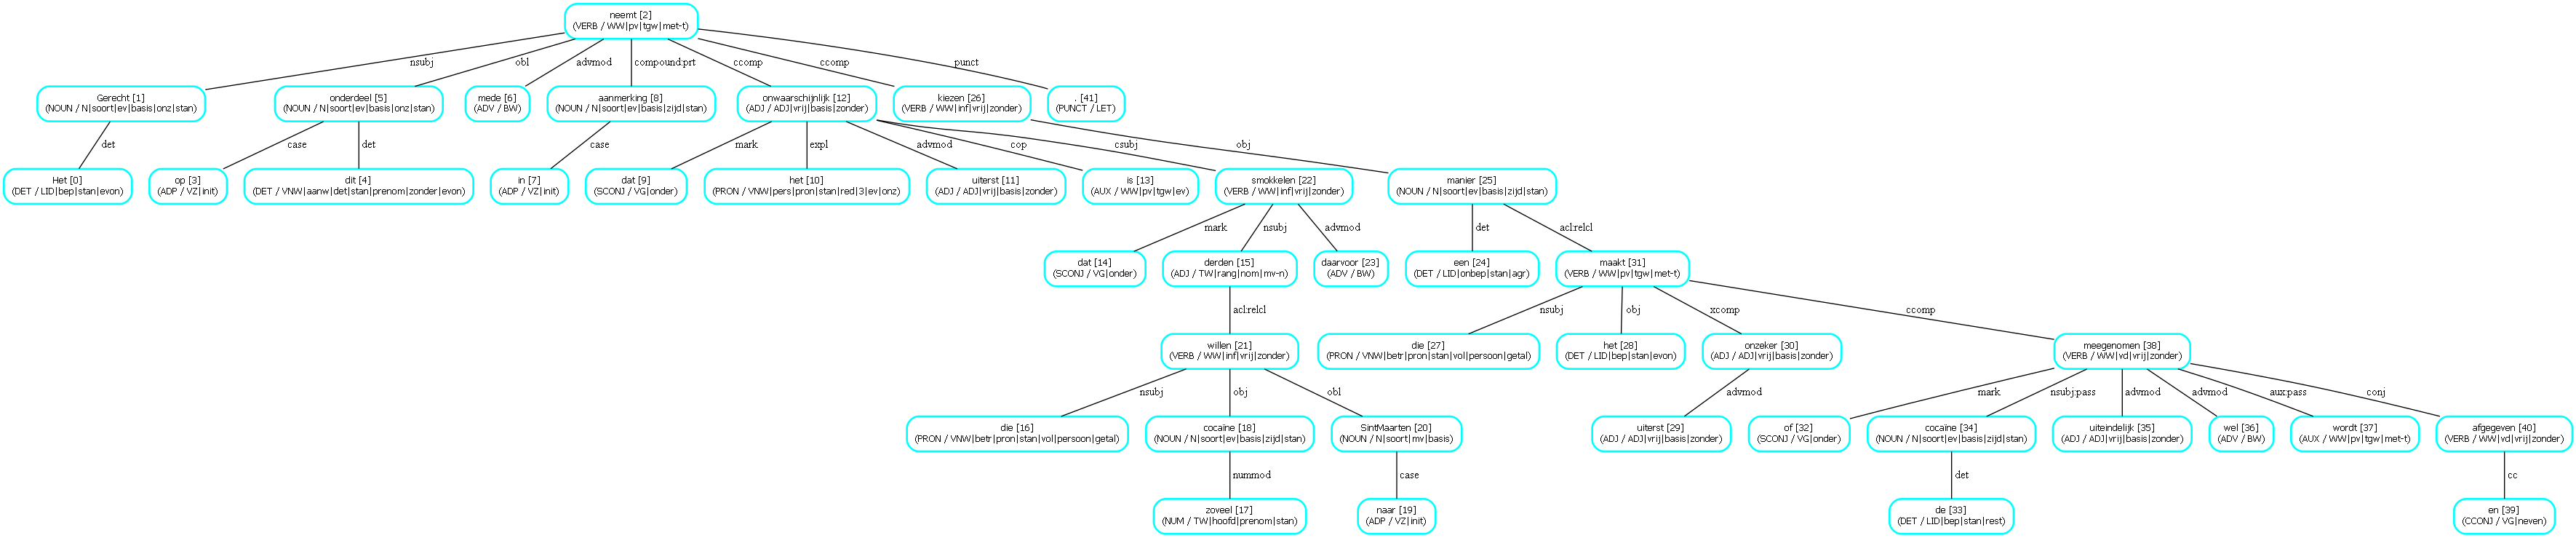

In [118]:
png = visualise_spacy_tree.create_png(nlp(txt))
display(Image(png))